In [69]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np

In [1]:
import pyspark
import sparknlp
import databricks.koalas as ks

## Resources

- Pyspark testing: [unit testing](https://blog.cambridgespark.com/unit-testing-with-pyspark-fb31671b1ad8), [dataframe testing](https://mungingdata.com/pyspark/testing-pytest-chispa/), [databricks summit video (holden karau)](https://www.youtube.com/watch?v=rPXmo99sOMo&t=40s)
- Spark NLP: [Package motivation & usage medium](https://towardsdatascience.com/introduction-to-spark-nlp-foundations-and-basic-components-part-i-c83b7629ed59), [topic modeling pyspark example](https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e), [docs](https://nlp.johnsnowlabs.com/docs/en/concepts)
- [Spark pipelines with mlflow](https://towardsdatascience.com/object-oriented-machine-learning-pipeline-with-mlflow-for-pandas-and-koalas-dataframes-ef8517d39a12)
- [Clustering embeddings vs LDA](https://arxiv.org/pdf/2004.14914.pdf): Can't get significantly better than LDA, but clustering of embeddings + reranking was computationally faster
- [Re-ranking of topic words](https://arxiv.org/pdf/1903.12542.pdf) - Using IDF weighting TFIDF (where D=topic) with 10-20 words provides better interpretability of LDA produced topics

## Load Data

In [2]:
spark = sparknlp.start()

In [70]:
sparknlp.version()
spark.version

'2.6.1'

'2.4.0'

In [46]:
data_path = '../data/ticket_comments_2020-09.csv'

In [47]:
#multiline text
!head -n5 ../data/ticket_comments_2020-09.csv

ticket_id,cleaned_text
45039,"Hi Leila, Hope you're having a nice week! Unfortunately, since we did not hear back regarding this policy, we have flat cancelled the renewal term and cancelled the original policy with an effective date of 12/20/19.  Please see the attached cancellation endorsement. Please let me know if you have any additional questions or concerns. Sincerely, Dana‍ Attune Customer Care Center Insurance coverage cannot be bound, added, deleted, changed or renewed unless the request is accepted and confirmed in writing by Attune on behalf of the underwriting insurance company. This email and any attachments may be confidential or proprietary and is intended solely for use of the individual or entity to which it is addressed. Any review, use, disclosure, distribution or copying of this email is prohibited except by or on behalf of the intended recipient. If you received this message in error or are not the intended recipient, please delete or destroy the email message and 

### Pandas

In [48]:
pdf = pd.read_csv(data_path, header=None, names=("ticket_id", "doc"))

In [49]:
pdf.count()

ticket_id    68636
doc          68636
dtype: int64

In [38]:
pdf.head(2)

ticket_id                                                doc
0      45039  Hi Leila,\n\nHope you're having a nice week!\n...
1      72367  Hi Peter,\n\nI wanted to follow up regarding t...

### Spark, define schema

In [50]:
# Import data types
from pyspark.sql.types import *
# The schema is encoded in a string.
schemaString = "ticket_id text"
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)

In [54]:
df = spark.read.csv(path=data_path, header=True, multiLine=True, schema=schema)

In [56]:
df.head(2)

[Row(ticket_id='45039', text="Hi Leila, Hope you're having a nice week! Unfortunately, since we did not hear back regarding this policy, we have flat cancelled the renewal term and cancelled the original policy with an effective date of 12/20/19.  Please see the attached cancellation endorsement. Please let me know if you have any additional questions or concerns. Sincerely, Dana\u200d Attune Customer Care Center Insurance coverage cannot be bound, added, deleted, changed or renewed unless the request is accepted and confirmed in writing by Attune on behalf of the underwriting insurance company. This email and any attachments may be confidential or proprietary and is intended solely for use of the individual or entity to which it is addressed. Any review, use, disclosure, distribution or copying of this email is prohibited except by or on behalf of the intended recipient. If you received this message in error or are not the intended recipient, please delete or destroy the email message

In [57]:
df.count()

68631

### Koalas

In [61]:
kdf = ks.read_csv(path=data_path, multiLine=True)

In [62]:
kdf.head(2)

ticket_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         cleaned_text
0      45039                                                                                                                                                                                                                                                                                                                                           Hi Leila, Hope you're having a nice week! Unfortunately, since we did not hear back regarding this policy, we have flat cancelled the renewal term and cancelled the original policy with an effective date of 12/20/19.  Please see the attached cancellation endorsement. Please let me know if you have any additional questions or concerns. Sincerely, Dana‍ Attune Customer Care Center Insurance coverage cannot be bound, added, deleted, changed or renewed unless the request is accepted and confirmed in writing by Attune on behalf of the underwriting insurance company. This email and any attachments may be confidential or proprietary and is intended solely for use of the individual or entity to which it is addressed. Any review, use, disclosure, distribution or copying of this email is prohibited except by or on behalf of the intended recipient. If you received this message in error or are not the intended recipient, please delete or destroy the email message and any attachments or copies and notify the sender by return email.
1      72367  Hi Peter, I wanted to follow up regarding this account. We reached out on March 18th, April 22nd and April 25th regarding this policy, requesting the proof of coverage elsewhere so that we could process this cancellation. We received the attached letter directly from the insured requesting additional information on why this cancellation has not been processed. Please note, for us to review and begin processing this request, we do require proof of coverage elsewhere, effective 3/6/19.  Please send proof of coverage elsewhere and we will be more than happy to review the cancellation request. Please let me know if you have any additional questions or concerns. Sincerely, Dana‍ Attune Customer Care Center Insurance coverage cannot be bound, added, deleted, changed or renewed unless the request is accepted and confirmed in writing by Attune on behalf of the underwriting insurance company. This email and any attachments may be confidential or proprietary and is intended solely for use of the individual or entity to which it is addressed. Any review, use, disclosure, distribution or copying of this email is prohibited except by or on behalf of the intended recipient. If you received this message in error or are not the i

In [64]:
kdf.ticket_id.nunique()

68631

In [24]:
text_col = 'text'

### Check for nulls and validate

In [66]:
df.select(F.countDistinct('ticket_id').alias('nunique')).show()

+-------+
|nunique|
+-------+
|  68631|
+-------+



In [71]:
kdf[~kdf.cleaned_text.isnull()].count()

ticket_id       68631
cleaned_text    68631
dtype: int64

In [67]:
df.filter(F.col(text_col).isNotNull()).count()

68631

## Pipeline with Spark NLP

In [251]:
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml import Pipeline
from sparknlp import Finisher
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import SentenceDetector, Tokenizer,\
Normalizer, LemmatizerModel, StopWordsCleaner
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from pyspark.ml.feature import HashingTF, IDF, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [76]:
# pipeline_dl = PretrainedPipeline(name='explain_document_dl', lang='en')
# pipeline_ml = PretrainedPipeline(name='explain_document_ml', lang='en')

explain_document_dl download started this may take some time.
Approx size to download 168.4 MB
[OK!]


### Test data

In [99]:
sentences = [
    ['Hello, this is an example sentence'],
    ['And this is a second sentence.']
]
test_data = spark.createDataFrame(sentences).toDF("text")

### Assemble

In [129]:
# ENGLISH_STOP_WORDS

In [271]:
document_assembler = DocumentAssembler().setInputCol('text').\
setOutputCol("document").setIdCol('ticket_id')
sentenceDetector = SentenceDetector().setInputCols(["document"]).setOutputCol("sentences")
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')
normalizer = Normalizer().setInputCols(['token']).setOutputCol('normal').setLowercase(True)
stopwords = StopWordsCleaner().setInputCols(['lemma']).\
setOutputCol('stop_lemmatized').setStopWords(list(ENGLISH_STOP_WORDS)).setCaseSensitive(False)
finisher = Finisher().setInputCols(['stop_lemmatized'])
tf = CountVectorizer(minDF=1.0, maxDF=.6, vocabSize=1000, inputCol='finished_stop_lemmatized', 
                     outputCol='tf')
# tf = HashingTF(numFeatures=1000, inputCol="finished_stop_lemmatized", outputCol="tf")
idf = IDF(minDocFreq=5, inputCol='tf', outputCol= 'tfidf')
lda = LDA(featuresCol='tfidf', maxIter=20, k=10)
# word_embeddings=WordEmbeddingsModel.pretrained()\
#  .setInputCols(['document','normal'])\
#  .setOutputCol('embeddings')

In [235]:
lemmatizer = LemmatizerModel.pretrained().setInputCols(['normal']).setOutputCol('lemma')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [272]:
pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer, 
            normalizer,
            lemmatizer,
            stopwords,
            finisher,
            tf,
            idf,
            lda
           ])

### Fit & Transform

In [270]:
# df.head(1000)

In [273]:
pipeline_fit = pipeline.fit(df.head(10000))

Py4JJavaError: An error occurred while calling o9219.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 444.0 failed 1 times, most recent failure: Lost task 0.0 in stage 444.0 (TID 2481, localhost, executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3255)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3255)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [241]:
annotated_df = pipeline_fit.transform(test_data)

In [242]:
annotated_df.columns

['text', 'finished_stop_lemmatized', 'tf', 'tfidf', 'topicDistribution']

In [246]:
annotated_df.select("tfidf").show(truncate=False, vertical=True)

-RECORD 0--------------------
 tfidf | (3,[0,1],[0.0,0.0]) 
-RECORD 1--------------------
 tfidf | (3,[2],[0.0])       



### Extract topics

In [261]:
# pipeline.getStages()
lda_model = pipeline_fit.stages[-1]

In [262]:
tf_model = pipeline_fit.stages[-3]

In [263]:
tf_model.vocabulary

['example', 'hello', 'second']

In [264]:
vocab = tf_model.vocabulary
def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]
udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))

In [265]:
lda_model.describeTopics().show()

+-----+-----------+--------------------+
|topic|termIndices|         termWeights|
+-----+-----------+--------------------+
|    0|  [0, 1, 2]|[0.34845575135732...|
|    1|  [2, 1, 0]|[0.34787388235635...|
|    2|  [1, 2, 0]|[0.33898083938953...|
|    3|  [0, 2, 1]|[0.35819008139624...|
|    4|  [2, 1, 0]|[0.36097680216218...|
|    5|  [1, 2, 0]|[0.35378555436051...|
|    6|  [0, 1, 2]|[0.36529618988536...|
|    7|  [0, 1, 2]|[0.39420039851300...|
|    8|  [1, 0, 2]|[0.34710663742579...|
|    9|  [1, 0, 2]|[0.36795369646242...|
+-----+-----------+--------------------+



In [266]:
num_top_words = 7
topics = lda_model.describeTopics(maxTermsPerTopic=num_top_words)\
.withColumn('topicWords', udf_to_words(F.col('termIndices')))
topics.show(truncate=False)

+-----+-----------+--------------------------------------------------------------+------------------------+
|topic|termIndices|termWeights                                                   |topicWords              |
+-----+-----------+--------------------------------------------------------------+------------------------+
|0    |[0, 1, 2]  |[0.34845575135732215, 0.32929863005118537, 0.3222456185914925]|[example, hello, second]|
|1    |[2, 1, 0]  |[0.3478738823563551, 0.3435750629852029, 0.308551054658442]   |[second, hello, example]|
|2    |[1, 2, 0]  |[0.3389808393895302, 0.3309165465661625, 0.3301026140443073]  |[hello, second, example]|
|3    |[0, 2, 1]  |[0.3581900813962499, 0.3211140847621766, 0.3206958338415735]  |[example, second, hello]|
|4    |[2, 1, 0]  |[0.36097680216218786, 0.3301787670473508, 0.30884443079046137]|[second, hello, example]|
|5    |[1, 2, 0]  |[0.3537855543605119, 0.3512499360464375, 0.2949645095930506]  |[hello, second, example]|
|6    |[0, 1, 2]  |[0.365296

### Pretrained Pipelines

In [80]:
# finisher = Finisher().setInputCols(["token", "lemma", "pos"])
# explain_pipeline_model = PretrainedPipeline("explain_document_ml").model

# pipeline = Pipeline() \
#     .setStages([
#         explain_pipeline_model,
#         finisher
#         ])

# model = pipeline.fit(data)
# annotations_finished_df = model.transform(data)
test_annotations = pipeline_ml.transform(test_data)

In [105]:
test_annotations.columns

['text', 'document', 'sentence', 'token', 'spell', 'lemmas', 'stems', 'pos']

In [106]:
test_annotations.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|               spell|              lemmas|               stems|                 pos|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Hello, this is an...|[[document, 0, 33...|[[document, 0, 33...|[[token, 0, 4, He...|[[token, 0, 4, He...|[[token, 0, 4, He...|[[token, 0, 4, he...|[[pos, 0, 4, UH, ...|
|And this is a sec...|[[document, 0, 29...|[[document, 0, 29...|[[token, 0, 2, An...|[[token, 0, 2, An...|[[token, 0, 2, An...|[[token, 0, 2, an...|[[pos, 0, 2, CC, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--

## Billing Ticket Preprocessing

In [1]:
!head -5 ../data/ticket_comments_billing_r2.csv

ticket_id,created_at,author_name,author_id,body,via_channel,rank
77812,2019-09-23 15:43:44.000000,Dana H.,370906285031,"Hi Andrea,

Thank you for your patience.



In [1110]:
# data_path = '../data/ticket_comments_billing_r2.csv'
data_path = '../data/eligibility_email_tix.csv'

df = pd.read_csv(data_path,
                names=('ticket_id','created','author','aid','body','channel','rank'))

In [1111]:
df.sort_values('ticket_id').head()

ticket_id                     created              author           aid  \
1    142463  2019-10-07 15:20:34.000000     Jessica Peralta  368935634672   
2    146767  2019-10-02 14:06:39.000000  Jennifer Villarino  369350680371   
3    151482  2019-10-02 07:50:26.000000        Jessica Shin  362691433731   
4    151909  2019-10-01 12:07:05.000000        Mark Riordan  368219184811   
5    152168  2019-10-01 13:11:04.000000         Nipon Samad  384681461572   

                                                body channel rank  
1  Hi Gretchen,\n\nSorry for the delay! It looks ...     web    1  
2  Is this the request to add location 3?\n\n \n\...   email    1  
3  Dear Nipon,\n\n \n\nI am waiting on a response...   email    1  
4  Hello Andrianna:\n\nThanks for your reply.\n\n...   email    1  
5  Good Morning Garry,\n\nThank you for providing...     web    1

### Define Token Specs

In [915]:
import re
import string
from collections import namedtuple, OrderedDict
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
email_pattern = r"[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}"
punct_pattern = r"[!\"#$%&\'()*+,./:;=?@\[\\\]^`{}~]+"

TokenSub = namedtuple("TokenSub", ["pattern", "repl"])

token_specifications = OrderedDict({
    "GREETING": TokenSub(r"(dear|hi|hello|hey|good ?(afternoon|morning|evening|day)?)( \w+)?[,!]*\n+", "")
    ,"PHONE_SIGNATURE": TokenSub(r"Sent (from|via).+(?=(i?phone|windows|TMobile|att|[45]g lte|spring|samsung|galaxy))(.|\n)*", "")
    ,"ATTUNE_FOOTER": TokenSub(r"((sincerely|kind regards),\n+)?\w+\n+attune customer care(.|\n)*", "")
    ,"BROKER_FOOTER": TokenSub(r"(sincerely|thanks?( you)?|(kind|warm )?regards).{0,15}[.,!]*\n+(.|\n)+", "")
    ,"SIGNATURE": TokenSub(r"(\n+[\w\|:.\(\), ]{1,40}\n+)(?=([\w\|@:.\(\)\/\[\], ]{5,75}\n+){3,7})(.|\n)*", "")
    ,"CONFIDENTIALITY_FOOTER": TokenSub(r"This email and any(.|\n)+(sender by return|transmitted by this) email", "")
    ,"ATTUNE_SUBMITTED_FROM": TokenSub(r"Submitted from: https://.*attune.+", "")
    ,"EMAIL_REPLY": TokenSub(r"from:.+\n+((sent|to|cc|date|subject):.+\n*)+(.|\n)*", "")
    ,"NEWLINES": TokenSub(r"(\s?\n\s?)+", "")
    ,"ACCT_PH": TokenSub(r"\d{10}", "<ACCT_PH>")
    ,"POLICY": TokenSub(r"[a-zA-Z0-9]{11,28}\d{7}", "<POLICY>")
    ,"EMAIL": TokenSub(email_pattern, "<EMAIL>")
    ,"URL": TokenSub(r"[a-zA-Z0-9]{18,35}", "")
})

def repl(match_object, token_specs, replace=True):
    """
    Given a match_object obtained from re.search(token_regex, string)
    where token_regex is built from token_specs, return a replacement pattern
    corresponding to the token type found (if this method is used in a re.sub 
    expression for text preprocessing, for example) or return the token_type found
    if being used for exploration
    
    Args:
        match_object (re.match object): from token_regex match on some string
        token_specs (dict(string, TokenSub)): specifies token name, pattern, repl
        replace (bool, optional): default True. Returns repl pattern if True else
            <token_type>

    Returns:
        string, either repl or token_type

    
    """
    token_type = match_object.lastgroup
    if replace:
        return token_specs[token_type].repl
    return f"<{token_type}>"


def make_token_regex(token_specs):
    token_regex = "|".join(
        [
            f"(?P<{token_type}>{tokensub.pattern})"
            for token_type, tokensub in token_specs.items()
        ]
    )
    return token_regex


def preprocess(text: str, token_specs=token_specifications, replace=True):
    text = text.encode("ascii", errors="ignore").decode()
    text = text.lower()
    text = re.sub(r"[\|_*&<>\-]+","",text) #special characters
    text = re.sub(r" +"," ", text) #excess whitespace
    text = re.sub(r"((\r| )+\n|\n(\r| )+)","\n", text) #whitespace-newline
    text = re.sub(
        make_token_regex(token_specs),
        lambda x: repl(x, token_specs, replace=replace),
        text,
        flags=re.IGNORECASE,
    )
    text = re.sub(punct_pattern, " ", text) #punctuation
    text = re.sub(r'\d+', " ", text) #numbers
    text = " ".join(text.strip().split()) #excess whitespace
    return text

### Examine preprocessing of random sample

In [629]:
samp = df.sample(n=1).body.iloc[0]

In [16]:
print(samp)
print('--P'*30)
print('\n')
print(preprocess(samp, replace=False))

### Check Token Extraction Rate for sub-sample

In [7]:
from collections import Counter
from collections import defaultdict

In [8]:
samp_df = df.sample(1000)

In [422]:
def get_token_extraction_fraction(df , tid_col = 'ticket_id', text_col='body'):
    
    #preprocess sample docs
    result = []
    for tup in df[[tid_col,text_col]].itertuples():
        result.append(
            (tup[1], preprocess(tup[2], replace=False))
            )
    
    #count tokens found in all docs & track tids that have tokens
    token_tid_map = defaultdict(list)
    token_counts = Counter()
    for tid, processed in result:
        count = Counter(re.findall('<\w+>', processed))
        token_counts+=count
        for k in count:
            token_tid_map[k].append(tid)
            
    return token_counts, token_tid_map

In [1112]:
tc, ttm = get_token_extraction_fraction(df)

In [1114]:
df.count()

ticket_id    3423
created      3423
author       3423
aid          3423
body         3423
channel      3423
rank         3423
dtype: int64

In [1113]:
tc

Counter({'<GREETING>': 1941,
         '<NEWLINES>': 7198,
         '<ATTUNE_FOOTER>': 296,
         '<SIGNATURE>': 1831,
         '<BROKER_FOOTER>': 647,
         '<ATTUNE_SUBMITTED_FROM>': 380,
         '<EMAIL_REPLY>': 37,
         '<ACCT_PH>': 646,
         '<URL>': 525,
         '<EMAIL>': 219,
         '<POLICY>': 104,
         '<CONFIDENTIALITY_FOOTER>': 51,
         '<PHONE_SIGNATURE>': 17})

In [1115]:
[(k, len(v)) for k,v in ttm.items()]

[('<GREETING>', 1882),
 ('<NEWLINES>', 2610),
 ('<ATTUNE_FOOTER>', 296),
 ('<SIGNATURE>', 1831),
 ('<BROKER_FOOTER>', 647),
 ('<ATTUNE_SUBMITTED_FROM>', 380),
 ('<EMAIL_REPLY>', 37),
 ('<ACCT_PH>', 402),
 ('<URL>', 218),
 ('<EMAIL>', 183),
 ('<POLICY>', 89),
 ('<CONFIDENTIALITY_FOOTER>', 51),
 ('<PHONE_SIGNATURE>', 17)]

#### Find samples with no successful Footer extractions

In [1116]:
successes = []
for k in ttm.keys():
    if k not in ('<NEWLINES>', '<GREETING>', '<POLICY>', '<EMAIL>', '<ACCT_PH>'):
        successes.extend(ttm[k])

In [1117]:
df[~df.ticket_id.isin(successes)].count()

ticket_id    158
created      158
author       158
aid          158
body         158
channel      158
rank         158
dtype: int64

In [1174]:
samp = df[df.ticket_id.isin(successes)].sample(n=1).body.iloc[0]

In [1175]:
print(samp)
print('--P'*30)
print('\n')
print(preprocess(samp, replace=True))

do you accept Non-drug over the counter pharmacy items distributer? if yes what class code do i use?

------------------
Submitted from: https://app.attuneinsurance.com/accounts/new?existing-account=0534600856
--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P--P


do you accept nondrug over the counter pharmacy items distributer if yes what class code do i use


### Get max chars thresh

In [426]:
#preprocess sample docs
result = []
for tup in df[['ticket_id','body']].itertuples():
    result.append(
        (tup[1], preprocess(tup[2], replace=True))
        )

In [428]:
lens = []
for tid, processed in result:
    lens.append(len(processed))

In [432]:
%matplotlib notebook

In [430]:
import seaborn as sns

In [464]:
pd.Series(lens).describe()

count    10702.000000
mean       219.553728
std        358.317882
min          0.000000
25%         66.000000
50%        134.000000
75%        262.000000
max      13855.000000
dtype: float64

In [441]:
pdf = pd.DataFrame(result[1:], columns=('tid','doc'))

In [476]:
pdf[pdf.doc.map(lambda x: len(x)<250)].count()

tid    7812
doc    7812
dtype: int64

<IPython.core.display.Javascript object>


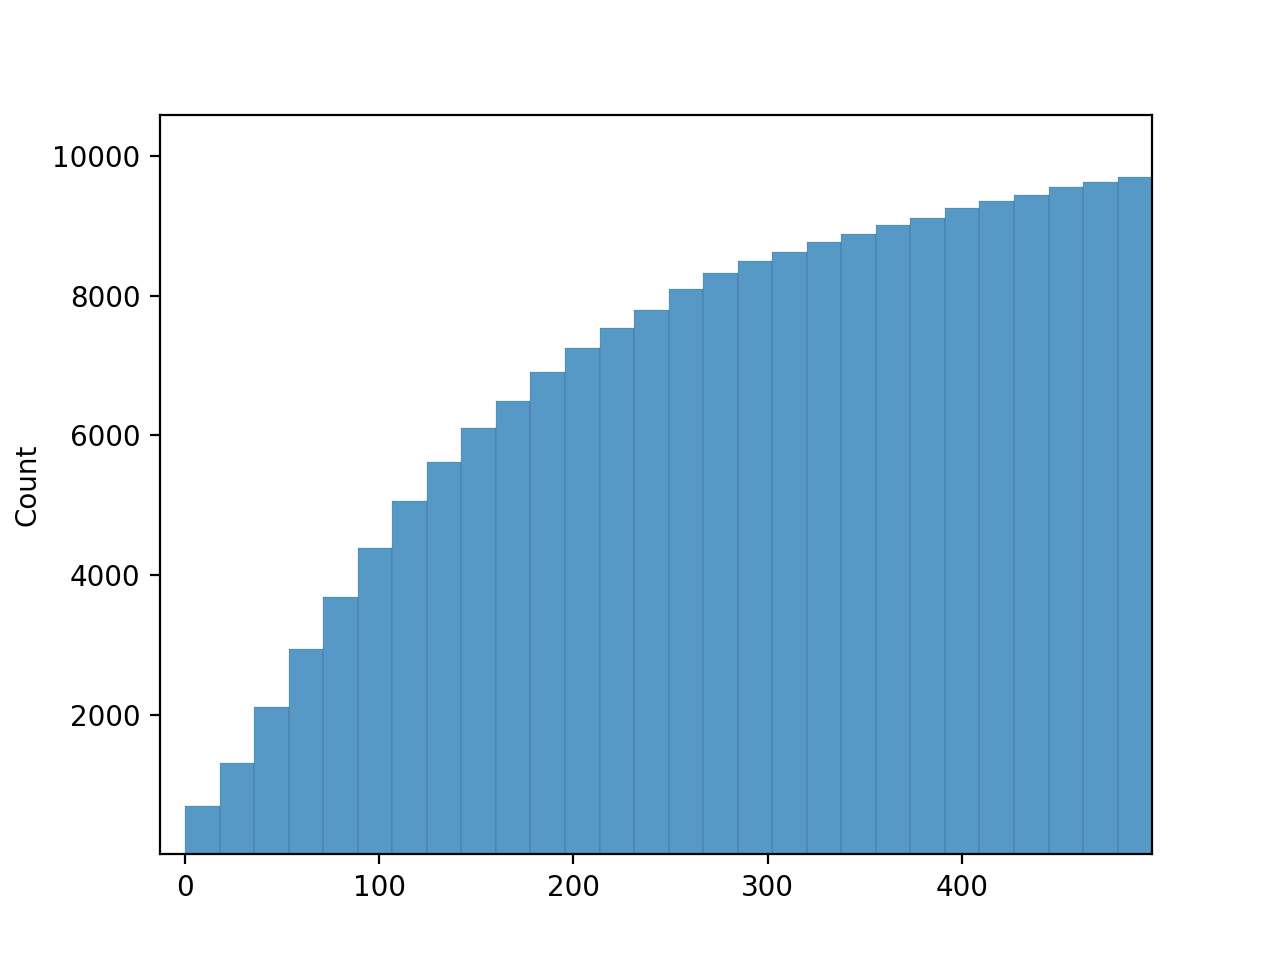

In [478]:
sns.histplot(lens, cumulative=True)

### Check Topic Coverage

In [1202]:
topics_df = pd.read_csv('../scripts/topic_analysis/topics.csv', usecols=[1])

In [1203]:
topics_df

topics
0  ['location', 'confirm', 'tenant', 'above', 'op...
1  ['class', 'questions', 'code', 'class code', '...
2  ['see', 'attached', 'request', 'below', 'see a...
3  ['advise', 'informatio', 'provide', 'following...
4  ['store', 'eligible', 'also', 'time', 'their',...
5  ['restaurant', 'new', 'ACCT_PH', 'loss', 'due'...
6  ['write', 'building', 'office', 'lro', 'covera...
7  ['policy', 'business', 'client', 'insurance', ...
8  ['portal', 'guidelines', 'underwriti', 'eligib...
9  ['company', 'help', 'name', 'one', 'EMAIL', 'w...

In [1204]:
data_df = pd.read_csv('../scripts/topic_analysis/dataframe.csv', usecols=(1,2,5,8,9,10,11,12,13))

~67% of docs have strongly defined dominant topics

In [1205]:
data_df['topic_weight_0'].round(1).value_counts().sort_index(ascending=False).cumsum(
)/(data_df['topic_weight_0'].round(1).value_counts().sort_index(ascending=False).cumsum().iloc[-1])

0.9    0.042068
0.8    0.101081
0.7    0.261759
0.6    0.410167
0.5    0.657026
0.4    0.846626
0.3    0.925504
0.2    0.928717
0.1    1.000000
Name: topic_weight_0, dtype: float64

In [1206]:
(data_df['topic_ind_0'].value_counts() /
 data_df['topic_ind_0'].value_counts().sum()).round(2).reset_index().merge(
topics_df.reset_index(), on='index')

index  topic_ind_0                                             topics
0      1         0.16  ['class', 'questions', 'code', 'class code', '...
1      9         0.15  ['company', 'help', 'name', 'one', 'EMAIL', 'w...
2      5         0.13  ['restaurant', 'new', 'ACCT_PH', 'loss', 'due'...
3      3         0.12  ['advise', 'informatio', 'provide', 'following...
4      2         0.10  ['see', 'attached', 'request', 'below', 'see a...
5      0         0.10  ['location', 'confirm', 'tenant', 'above', 'op...
6      8         0.08  ['portal', 'guidelines', 'underwriti', 'eligib...
7      6         0.07  ['write', 'building', 'office', 'lro', 'covera...
8      7         0.07  ['policy', 'business', 'client', 'insurance', ...
9      4         0.02  ['store', 'eligible', 'also', 'time', 'their',...

In [1230]:
print(data_df[(data_df['topic_ind_0'] == 6) & (
    data_df['topic_weight_0'] >= .55)].sample(n=1).doc.values[0])

Hi Amy,

I believe this is displaying this way because there is no building coverage on building 2. If you go towards the end, all 3 classifications are listed.

Amit‍
Attune Customer Care Team

Process endorsements in seconds straight through the Attune Portal
Check out our help center

* * *

_Insurance coverage cannot be bound, added, deleted, changed or renewed unless the request is accepted and confirmed in writing by Attune on behalf of the underwriting insurance company._

_This email and any attachments may be confidential or proprietary and is intended solely for use of the individual or entity to which it is addressed. Any review, use, disclosure, distribution or copying of this email is prohibited except by or on behalf of the intended recipient. If you received this message in error or are not the intended recipient, please delete or destroy the email message and any attachments or copies and notify the sender by return email._


<IPython.core.display.Javascript object>


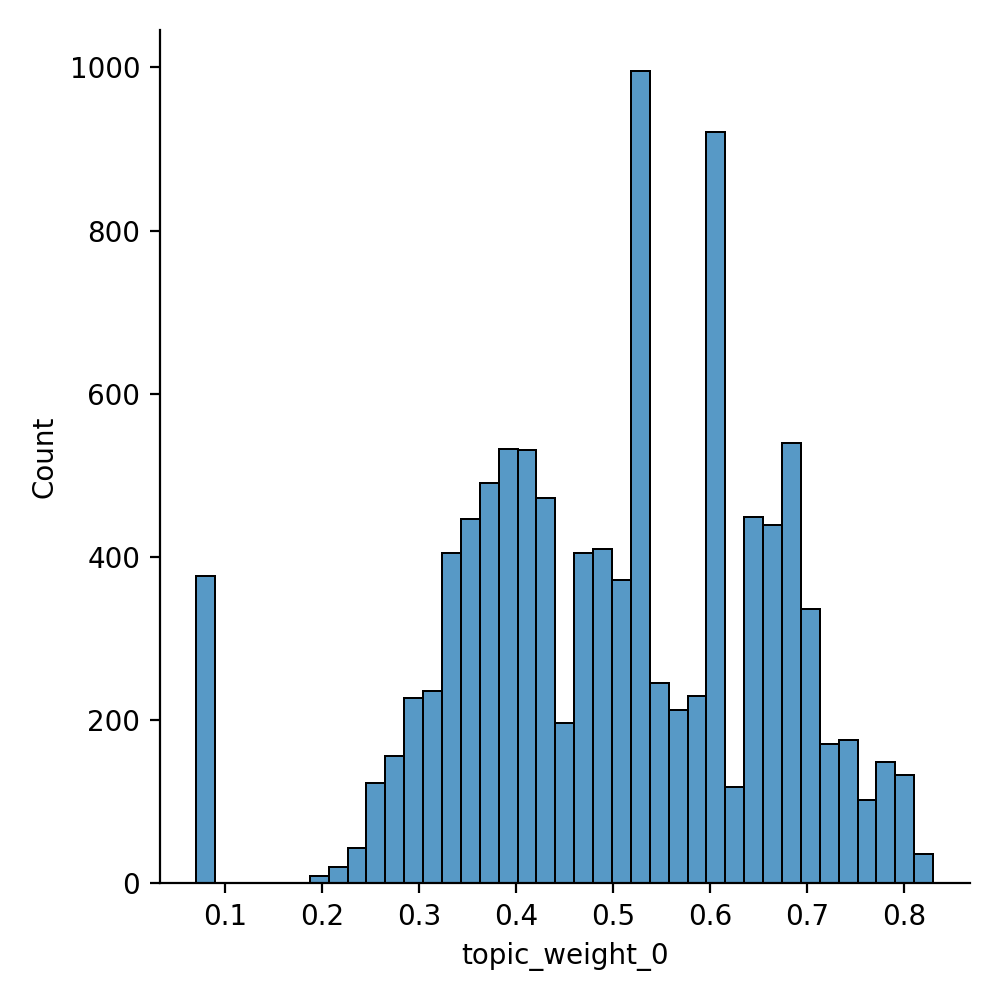

In [1029]:
sns.displot(data_df['topic_weight_0'].round(2))

<IPython.core.display.Javascript object>


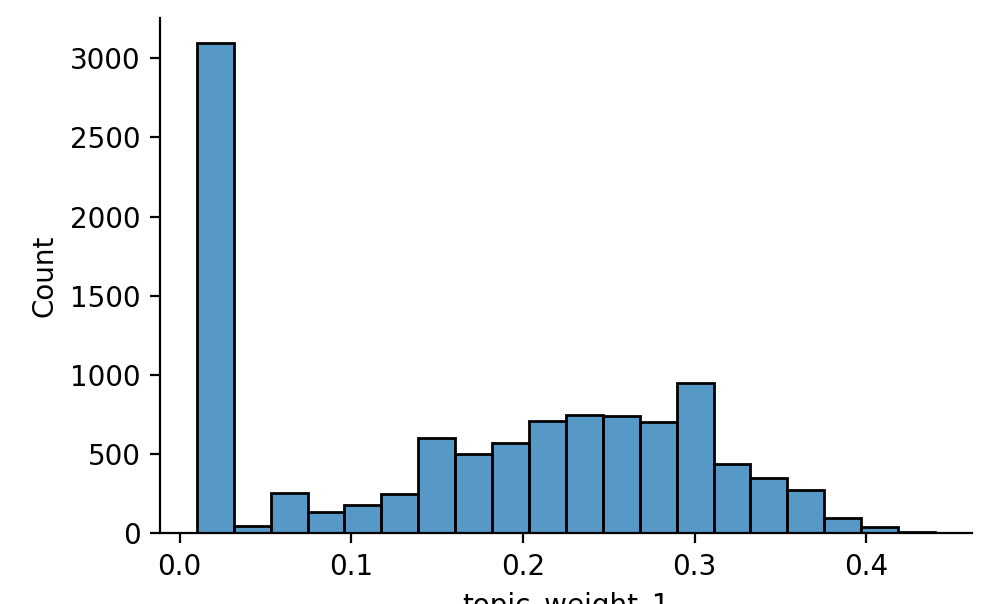

In [1023]:
sns.displot(data_df['topic_weight_1'].round(2))

In [1019]:
data_df[data_df['topic_weight_0']>=0.55].count()

ticket_id         4654
created           4654
doc               4654
topic_ind_0       4654
topic_ind_1       4654
topic_ind_2       4654
topic_weight_0    4654
topic_weight_1    4654
topic_weight_2    4654
dtype: int64